In [73]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split


# Define the classes
classes = ['cherry', 'strawberry', 'tomato']
data_dir = './train_data'

# Dictionary to store the loaded images
data = {}

# List of images to exclude
excluded_images = {
    'cherry_0055.jpg',
    'cherry_0105.jpg',
    'cherry_0147.jpg',
    'strawberry_0931.jpg',
    'tomato_0087.jpg'
}

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = []
    
    # Loop through all files in the class directory
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.jpg'):  # Check for image files
            # Check if the file should be excluded
            if file_name in excluded_images:
                continue  # Skip this file
            file_path = os.path.join(class_dir, file_name)
            
            # Open the image and append it to the list
            img = Image.open(file_path)
            images.append(img)
    
    # Store images for this class
    data[class_name] = images


# Example: Accessing images from the 'cherry' class
print(f'Loaded {len(data["cherry"])} images from cherry class.')
print(f'Loaded {len(data["strawberry"])} images from strawberry class.')
print(f'Loaded {len(data["tomato"])} images from tomato class.')

Loaded 1492 images from cherry class.
Loaded 1494 images from strawberry class.
Loaded 1494 images from tomato class.


In [74]:

import random


def set_seed(seed):
    random.seed(seed)  # For Python random
    np.random.seed(seed)  # For NumPy random
    torch.manual_seed(seed)  # For PyTorch CPU random
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For PyTorch GPU random
        torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
    torch.backends.cudnn.deterministic = True  # Make sure CUDA computations are deterministic
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode to make it reproducible

# Set a seed value, e.g., 42
set_seed(42)


In [75]:
# Define the target resolution
target_size = (300, 300)

# Dictionary to hold filtered data
filtered_data = {}

count = 0
# Iterate through the classes
for class_name, images in data.items():
    filtered_images = []
    
    # Check each image for its resolution
    for img in images:
        if img.size == target_size:
            filtered_images.append(img)  # Keep images that match 300x300
        else:
            count += 1
    
    # Store only the filtered images in the new dictionary
    filtered_data[class_name] = filtered_images

# Example: Accessing filtered images
print(f'Filtered {len(filtered_data["cherry"])} images from cherry class.')
print(f'Filtered {len(filtered_data["strawberry"])} images from strawberry class.')
print(f'Filtered {len(filtered_data["tomato"])} images from tomato class.')
print(f'Removed {count} images in total.')
print(f'Filtered {len(filtered_data["cherry"])+len(filtered_data["strawberry"])+len(filtered_data["tomato"])} images in total.')


Filtered 1475 images from cherry class.
Filtered 1477 images from strawberry class.
Filtered 1476 images from tomato class.
Removed 52 images in total.
Filtered 4428 images in total.


In [76]:
import numpy as np
from collections import defaultdict

def detect_and_filter_rgb_outliers(image_data, thresholds):
    filtered_data = defaultdict(list)
    outliers = []
    grayscale_count = 0
    total_input_images = sum(len(images) for images in image_data.values())
    
    for class_name, images in image_data.items():
        for img in images:
            img_np = np.array(img)  # Convert image to NumPy array
            
            if len(img_np.shape) == 2:  # Grayscale image (only height and width)
                grayscale_count += 1
                continue
            
            # Calculate the mean pixel intensity for each RGB channel
            mean_channels = np.mean(img_np, axis=(0, 1))
            
            # Detect if any of the channels are outside their specific thresholds
            condition = (mean_channels < [t[0] for t in thresholds]) | (mean_channels > [t[1] for t in thresholds])
            if np.any(condition):
                outliers.append(img)
            else:
                filtered_data[class_name].append(img)
    
    total_processed_images = sum(len(images) for images in filtered_data.values()) + len(outliers)
    
    print(f"Input images: {total_input_images}")
    print(f"Processed images: {total_processed_images}")
    print(f"Removed Grayscale images: {grayscale_count}")
    print(f"RGB images: {total_processed_images - grayscale_count}")
    print(f"Outliers: {len(outliers)}")
    print(f"Images in filtered_data: {sum(len(images) for images in filtered_data.values())}")
    
    return dict(filtered_data), outliers

# Define channel-specific thresholds based on the distributions
thresholds = [
    (27, 238),  # Red channel (low, high)
    (14, 220),  # Green channel (low, high)
    (8, 218)    # Blue channel (low, high)
]

# Use the optimized function with new thresholds
filtered_data, rgb_outliers = detect_and_filter_rgb_outliers(filtered_data, thresholds)
print(f'\nFound {len(rgb_outliers)} potential RGB channel-based outliers out of {sum(len(images) for images in filtered_data.values()) + len(rgb_outliers)} total images.')
print(f'Filtered data contains {sum(len(images) for images in filtered_data.values())} images after RGB channel-based filtering.')

Input images: 4428
Processed images: 4427
Removed Grayscale images: 1
RGB images: 4426
Outliers: 144
Images in filtered_data: 4283

Found 144 potential RGB channel-based outliers out of 4427 total images.
Filtered data contains 4283 images after RGB channel-based filtering.


In [77]:
def normalize(data):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts image to tensor and normalizes to [0, 1]
    ])
    X_data = []
    y_labels = []

    label_mapping = {
        'cherry': 0,
        'strawberry': 1,
        'tomato': 2
    }

    # Step 1: Transform images directly without intermediate NumPy conversion
    for label, images in data.items():
        for img in images:
            img_transformed = transform(img)  # Apply transformation to normalize and convert to tensor
            X_data.append(img_transformed)
            y_labels.append(label_mapping[label])

    # Step 2: Stack tensors together
    X = torch.stack(X_data)  # Now, X will be of shape [num_images, 3, 300, 300]
    y = torch.tensor(y_labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

def get_dataloaders(batch_size):
    X_train, X_test, y_train, y_test = normalize(filtered_data)
    # Step 4: Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    # Check shapes
    print(f"Training X shape: {X_train.shape}, Training y shape: {y_train.shape}")
    print(f"Testing X shape: {X_test.shape}, Testing y shape: {y_test.shape}")
    return train_loader, test_loader


batch_size = 64
train_loader, test_loader = get_dataloaders(batch_size)

Training X shape: torch.Size([2998, 3, 300, 300]), Training y shape: torch.Size([2998])
Testing X shape: torch.Size([1285, 3, 300, 300]), Testing y shape: torch.Size([1285])


In [91]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):  # Use dropout_rate instead of decay for clarity
        super(CNN, self,).__init__()

        # First convolutional layer: input channels=3, output channels=16, kernel size=3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Max pooling layer to downsample
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 75 * 75, 128)  # Adjusting for 300x300 input size after pooling
        self.fc2 = nn.Linear(128, 3)  # Output size matches the number of classes (cherry, strawberry, tomato)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.04380980725546357)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply first conv layer, activation, and pooling
        x = self.pool(self.relu(self.conv1(x)))

        # Apply second conv layer, activation, and pooling
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output from convolutional layers
        x = x.view(-1, 32 * 75 * 75)

        # Apply first fully connected layer with dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout here

        # Apply second fully connected layer
        x = self.fc2(x)

        return x

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss
    

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=3):
        """
        Label smoothing loss for multi-class classification
        
        Args:
            smoothing (float): smoothing factor, typically between 0.0 and 0.2
            num_classes (int): number of classes in your dataset
        """
        super().__init__()
        self.smoothing = smoothing
        self.num_classes = num_classes
        self.confidence = 1.0 - smoothing
        
    def forward(self, pred, target):
        """
        Args:
            pred: predictions from model (N, C)
            target: target labels (N,)
        """
        pred = F.log_softmax(pred, dim=-1)
        
        # Create smoothed labels
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np
import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt


def train_and_evaluate(train_loader, val_loader, model, optimizer, loss_function, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total, correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions

        train_acc = 100 * correct / total
        # print(f"Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()  # Set the model to evaluation mode
        total, correct = 0, 0

        with torch.no_grad():  # No gradients needed during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get predicted class indices
                total += labels.size(0)
                correct += (predicted == labels).sum().item()  # Count correct predictions

        val_acc = 100 * correct / total
        # print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {val_acc:.2f}%")

    return val_acc

def objective(trial):
    kernel_size = trial.suggest_categorical("kernel_size", [2,3,4])


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    k_folds = 5
    dataset = train_loader.dataset
    indices = list(range(len(dataset)))
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_fold_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
        val_fold_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler)
        
        model = CNN().to(device)

        optimizer = optim.Adam(model.parameters(), lr=0.00020711569050274695)  
        val_accuracy = train_and_evaluate(
            train_fold_loader, val_fold_loader,
            model, optimizer, nn.CrossEntropyLoss(),
            device, num_epochs=8
        )

        fold_accuracies.append(val_accuracy)
        trial.report(val_accuracy, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(fold_accuracies)

def plot_optimization_history(study):
    fig = vis.plot_optimization_history(study)
    plt.show()

def run_optimization(train_loader, n_trials=10):
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
    )
    
    study.optimize(
        objective,
        n_trials=n_trials,
        timeout=3600  # 1 hour timeout
    )
    
    print('\nBest trial:')
    print('Value:', study.best_value)
    print('Params:', study.best_params)
    
    return study
study = run_optimization(train_loader)

[I 2024-10-22 18:54:51,470] A new study created in memory with name: no-name-f26e11bb-15c6-4999-b719-81a47da55d92
[I 2024-10-22 18:56:19,214] Trial 0 finished with value: 58.37351140790206 and parameters: {'kernel_size': 2}. Best is trial 0 with value: 58.37351140790206.
[I 2024-10-22 18:57:47,217] Trial 1 finished with value: 57.90411797440178 and parameters: {'kernel_size': 3}. Best is trial 0 with value: 58.37351140790206.
[I 2024-10-22 18:59:14,564] Trial 2 finished with value: 60.140456316082364 and parameters: {'kernel_size': 4}. Best is trial 2 with value: 60.140456316082364.
[I 2024-10-22 19:00:41,378] Trial 3 finished with value: 59.441012799109636 and parameters: {'kernel_size': 4}. Best is trial 2 with value: 60.140456316082364.
[I 2024-10-22 19:02:08,872] Trial 4 finished with value: 58.43928770172509 and parameters: {'kernel_size': 2}. Best is trial 2 with value: 60.140456316082364.
[I 2024-10-22 19:02:26,394] Trial 5 pruned. 
[I 2024-10-22 19:02:43,839] Trial 6 pruned. 
[


Best trial:
Value: 60.140456316082364
Params: {'kernel_size': 4}


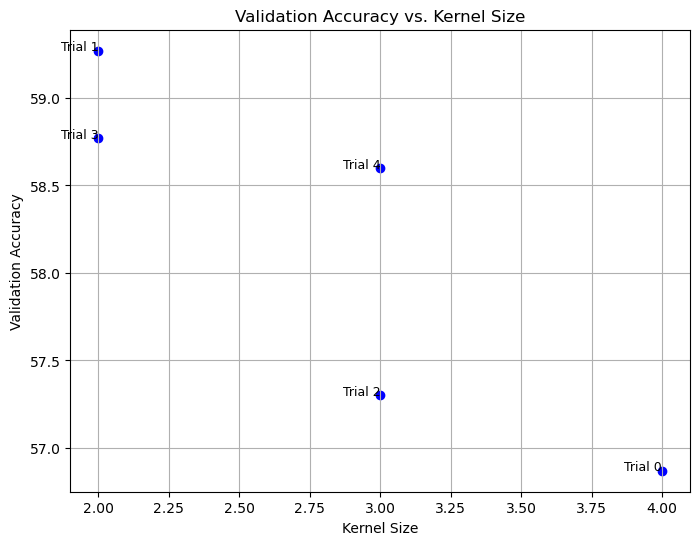

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
model = CNN().to(device)  # Move model to GPU if available

# Set up the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.00020711569050274695)
loss_fn = nn.CrossEntropyLoss() 

# Training and evaluation
num_epochs = 8
train_and_evaluate(train_loader, test_loader, model, optimizer, loss_fn, device, num_epochs)


Epoch [1/8], Validation Accuracy: 52.53%
Epoch [2/8], Validation Accuracy: 60.31%
Epoch [3/8], Validation Accuracy: 55.10%
Epoch [4/8], Validation Accuracy: 62.96%
Epoch [5/8], Validation Accuracy: 63.89%
Epoch [6/8], Validation Accuracy: 62.88%
Epoch [7/8], Validation Accuracy: 61.71%
Epoch [8/8], Validation Accuracy: 63.58%


63.57976653696498